<a href="https://www.kaggle.com/code/a0121543/mna-titanic?scriptVersionId=123987616" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Referencias
* Titanic Tutorial - https://www.kaggle.com/code/alexisbcook/titanic-tutorial

In [ ]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv", index_col="PassengerId")
print(train_data.shape)
train_data.head()

In [ ]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv", index_col="PassengerId")
print(test_data.shape)
test_data.head()

In [ ]:
# Porcentaje de valores nulos (NaN)
percentage_of_nan = train_data.isna().sum() * 100 / len(train_data)
percentage_of_nan

In [ ]:
# `Cabin` has ~77% of NaN values and it has alphanumeic values
# shall we just create a new col indicating if it has a cabin code?
train_data['has_cabin_code'] = train_data['Cabin'].isnull().astype(int)
train_data.drop('Cabin', axis=1, inplace=True)
train_data.head()

In [ ]:
from sklearn.impute import SimpleImputer

# Replace null values with the column's average
mean_imputer = SimpleImputer(strategy="mean")

# Replace the original "Age" column with the imputed data
train_data["Age"] = mean_imputer.fit_transform(train_data[["Age"]])

In [ ]:
# Replace null values with the column's most frequent value
most_frequent_imputer = SimpleImputer(strategy="most_frequent")
train_data["Embarked"] = most_frequent_imputer.fit_transform(train_data[["Embarked"]])

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
cat_cols_to_encode = ["Sex", "Embarked"]
for col_name in cat_cols_to_encode:
    train_data[col_name] = label_encoder.fit_transform(train_data[col_name])
train_data.head()

In [ ]:
def count_chars(s):
  if s is None:
    return 0
  else:
    return len(s)

train_data["name_chars_len"] = train_data["Name"].apply(count_chars)
train_data.head()

In [ ]:
train_data.isna().any()

In [ ]:
cat_cols = ["Pclass", "Sex", "Embarked"]

In [ ]:
train_data.describe()

In [ ]:
train_data.hist(bins=50, figsize=(12,8))

In [ ]:
!pip install transformers

# Experimento de feature engineering con zero-shot classification
La clasificación "zero-shot" (o clasificación de cero disparo) permite a un modelo clasificar ejemplos en categorías no vistas durante su entrenamiento. En otras palabras, el modelo es capaz de reconocer y clasificar objetos o conceptos que no ha encontrado previamente en su conjunto de datos de entrenamiento. <br/>
En este caso, se utiliza para clasificar el nombre de los pasajeros en diferentes idiomas con el objetivo de obtener una nueva columna o característica (language) que -hopefully- ayude a aumentar la precisión del modelo. <br/>

* Utilizamos el modelo "bart-large" entrenado con el dataset MultiNLI que se encuentra en HuggingFace: https://huggingface.co/facebook/bart-large-mnli
* Paper de BART: https://arxiv.org/abs/1910.13461

In [ ]:
from transformers import pipeline
classifier_pipeline = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

# `input_sequence` es el texto que queremos clasificar, en este caso, el nombre de un pasajero
input_sequence = 'Heikkinen, Miss. Laina'
# `label_candidate` son las posibles categorias en las que queremos que el modelo clasifique el nombre del pasajero
label_candidate = ['English', 'Spanish', 'German', 'Polish', 'French', 'Sweedish', 'Chinese','Portugess','Other']
r = classifier_pipeline(input_sequence, label_candidate)
r

In [ ]:
# Para obtener la categoria (label) con mayor probabilidad podemos hacer:
r['labels'][0]

In [ ]:
# Aqui aplicamos lo anterior a todas las filas de la columna `Name` para generar una nueva columna: `language`
# NOTA: Tarda como 50-60 min correr esta celda

def zero_shot_language(s):
    label_candidate = ['English', 'Spanish', 'German', 'Polish', 'French', 'Sweedish', 'Chinese','Portugess','Other']
    result = classifier_pipeline(s, label_candidate)
    return result['labels'][0]

train_data["language"] = train_data["Name"].apply(zero_shot_language)
train_data.head()

In [ ]:
# Una vez obtenida la nueva columna lo guardamos en un CSV para evitar tener que correr nuevamente la celda anterior
# en el futuro

train_data.to_csv('/kaggle/working/train_lang.csv',index=True)

In [ ]:
# Aqui convertimos `language` a categorias numericas

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_data["language"] = label_encoder.fit_transform(train_data["language"])
train_data.head()

# Familiy Size

In [ ]:
train_data['family_size'] = train_data.Parch + train_data.SibSp + 1
train_data.head()

# Ticket

In [ ]:
train_data["ticket_chars_len"] = train_data["Ticket"].apply(count_chars)
train_data.head()

In [ ]:
import re
# Function to check if a ticket contains only numbers or has letters
def is_number_only(ticket):
    if re.search('[a-zA-Z]', ticket):
        return 0
    else:
        return 1
train_data['ticket_only_numbers'] = train_data['Ticket'].apply(is_number_only)
train_data.head()

In [ ]:
# Drop `Name` and `Ticket`
train_data.drop(columns=['Name','Ticket'], axis=1, inplace=True)
train_data.head()

In [ ]:
train_data.describe()

In [ ]:
train_data.shape

In [ ]:
import matplotlib.pyplot as plt
train_data.hist(bins=10, figsize=(12,8))
plt.show()

In [ ]:
import seaborn as sns
# correlations before data scaling
train_data.corr()
corr_map = train_data.corr()
sns.set(rc = {'figure.figsize':(14,14)})
sns.heatmap(corr_map, vmin = -1, vmax = 1, cmap = "BuGn", annot= True, linewidths = 2)

In [ ]:
val_atp = train_data.boxplot(figsize=(16,8), showmeans=True)
val_atp.plot()
plt.show()

In [ ]:
train_data.head()

In [25]:
cols_to_onehot_encode = [
    "Pclass", "Embarked", "language",
]

train_data = pd.get_dummies(train_data, columns=cols_to_onehot_encode, drop_first=True).copy()
train_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,has_cabin_code,name_chars_len,family_size,ticket_chars_len,...,Embarked_1,Embarked_2,language_1,language_2,language_3,language_4,language_5,language_6,language_7,language_8
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,22.0,1,0,7.2500,1,23,2,9,...,0,1,0,0,1,0,0,0,0,0
2,1,0,38.0,1,0,71.2833,0,51,2,8,...,0,0,1,0,0,0,0,0,0,0
3,1,0,26.0,0,0,7.9250,1,22,1,16,...,0,1,0,0,1,0,0,0,0,0
4,1,0,35.0,1,0,53.1000,0,44,2,6,...,0,1,0,1,0,0,0,0,0,0
5,0,1,35.0,0,0,8.0500,1,24,1,6,...,0,1,1,0,0,0,0,0,0,0


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

num_cols = ['Age','SibSp','Parch','Fare','name_chars_len','family_size','ticket_chars_len']

num_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
#         ('log', FunctionTransformer(np.log))
    ]
)
columnTransformer = ColumnTransformer(transformers=[
    ('num_pipe', num_pipeline, num_cols)
])
train_data_scaled = train_data.copy()
train_data_scaled[num_cols] = columnTransformer.fit_transform(train_data_scaled[num_cols])
train_data_scaled

,Survived,Sex,Age,SibSp,Parch,Fare,has_cabin_code,name_chars_len,family_size,ticket_chars_len,...,Embarked_1,Embarked_2,language_1,language_2,language_3,language_4,language_5,language_6,language_7,language_8
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,-0.592481,0.432793,-0.473674,-0.502445,1,-0.427451,0.059160,0.819672,...,0,1,0,0,1,0,0,0,0,0
2,1,0,0.638789,0.432793,-0.473674,0.786845,0,2.590962,0.059160,0.455237,...,0,0,1,0,0,0,0,0,0,0
3,1,0,-0.284663,-0.474545,-0.473674,-0.488854,1,-0.535252,-0.560975,3.370717,...,0,1,0,0,1,0,0,0,0,0
4,1,0,0.407926,0.432793,-0.473674,0.420730,0,1.836359,0.059160,-0.273633,...,0,1,0,1,0,0,0,0,0,0
5,0,1,0.407926,-0.474545,-0.473674,-0.486337,1,-0.319651,-0.560975,-0.273633,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,1,-0.207709,-0.474545,-0.473674,-0.386671,1,-0.643052,-0.560975,-0.273633,...,0,1,0,0,0,0,0,0,1,0
888,1,0,-0.823344,-0.474545,-0.473674,-0.044381,0,0.111551,-0.560975,-0.273633,...,0,1,0,0,0,0,0,0,0,1
889,0,0,0.000000,0.432793,2.008933,-0.176263,1,1.405157,1.299429,1.184107,...,0,1,1,0,0,0,0,0,0,0


In [27]:
from sklearn.model_selection import train_test_split

X = train_data_scaled.copy()
y = train_data_scaled[["Survived"]].copy()
X.drop("Survived", axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y["Survived"], test_size = 0.2, random_state = 42)
X_train

,Survived,Sex,Age,SibSp,Parch,Fare,has_cabin_code,name_chars_len,family_size,ticket_chars_len,...,Embarked_1,Embarked_2,language_1,language_2,language_3,language_4,language_5,language_6,language_7,language_8
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,-0.592481,0.432793,-0.473674,-0.502445,1,-0.427451,0.059160,0.819672,...,0,1,0,0,1,0,0,0,0,0
2,1,0,0.638789,0.432793,-0.473674,0.786845,0,2.590962,0.059160,0.455237,...,0,0,1,0,0,0,0,0,0,0
3,1,0,-0.284663,-0.474545,-0.473674,-0.488854,1,-0.535252,-0.560975,3.370717,...,0,1,0,0,1,0,0,0,0,0
4,1,0,0.407926,0.432793,-0.473674,0.420730,0,1.836359,0.059160,-0.273633,...,0,1,0,1,0,0,0,0,0,0
5,0,1,0.407926,-0.474545,-0.473674,-0.486337,1,-0.319651,-0.560975,-0.273633,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,1,-0.207709,-0.474545,-0.473674,-0.386671,1,-0.643052,-0.560975,-0.273633,...,0,1,0,0,0,0,0,0,1,0
888,1,0,-0.823344,-0.474545,-0.473674,-0.044381,0,0.111551,-0.560975,-0.273633,...,0,1,0,0,0,0,0,0,0,1
889,0,0,0.000000,0.432793,2.008933,-0.176263,1,1.405157,1.299429,1.184107,...,0,1,1,0,0,0,0,0,0,0


In [28]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [29]:
importances = dt_classifier.feature_importances_
print(importances)

[0.1007348  0.2943741  0.15276368 0.03086795 0.00450116 0.10702116
 0.02288825 0.02808015 0.11868836 0.08124206 0.0258084  0.02841335
 0.00461658]


[ 4 12  6 10  7 11  3  9  0  5  8  2  1]


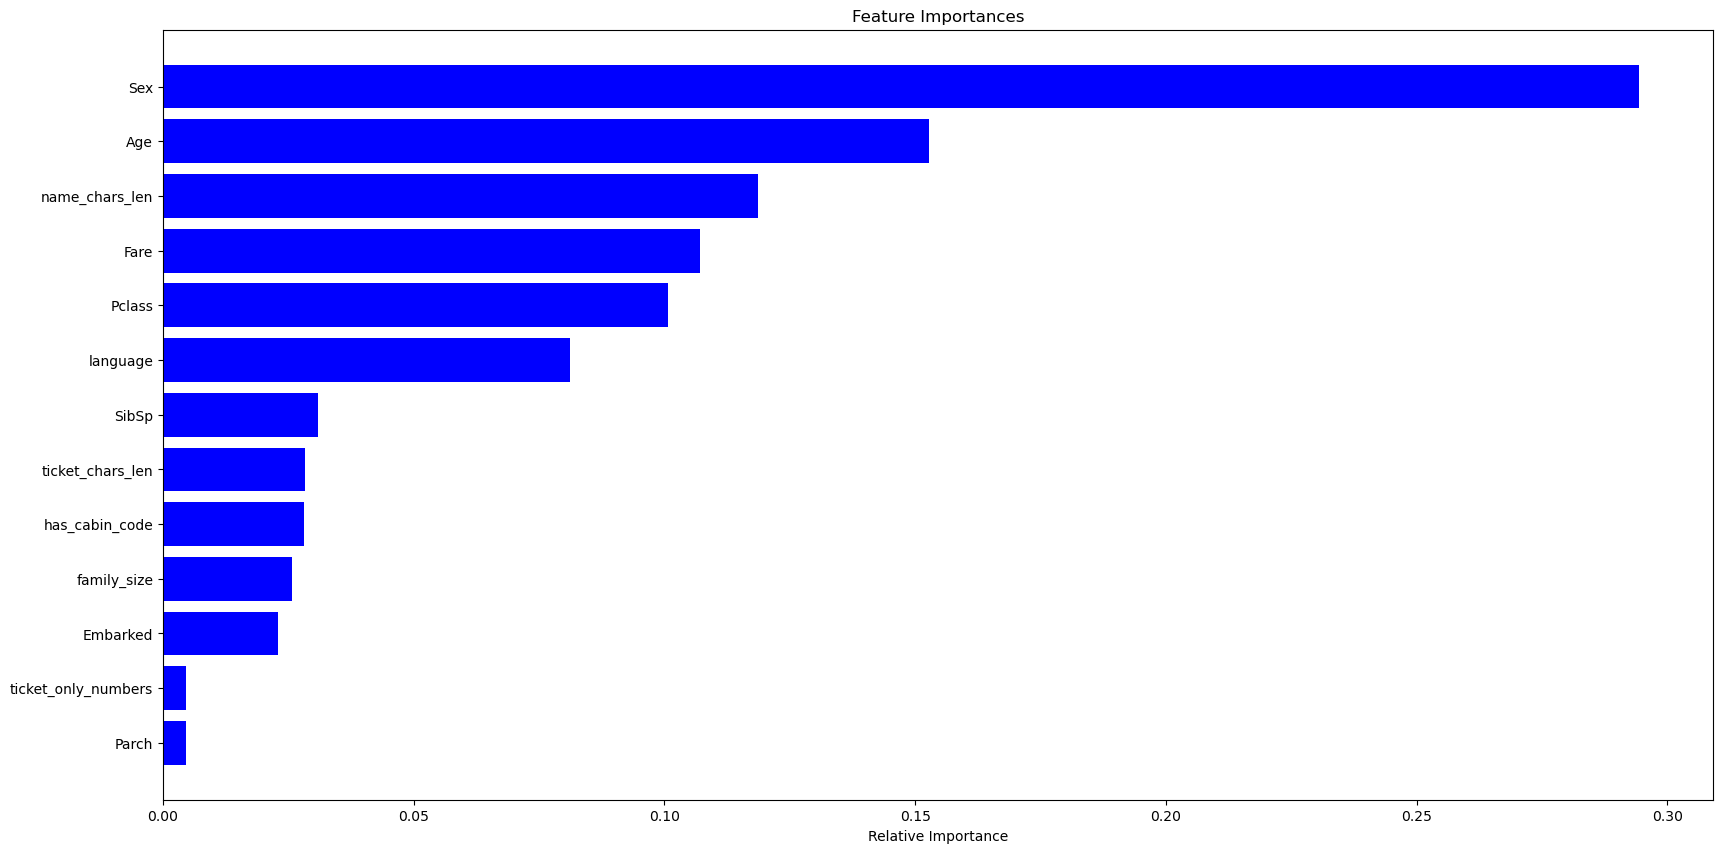

In [31]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)
indices = np.argsort(importances)

print(indices)

plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

def get_models():
  modelos = list()
  nombres = list()
  # LR - Logistic Regression
  modelos.append(LogisticRegression(penalty='l2', solver='newton-cg', max_iter=20000, C=100, random_state=42, class_weight="balanced", n_jobs=30))
  nombres.append("LR - Logistic Regression")
  
  # RF - Bosque Aleatorio
  modelos.append(RandomForestClassifier(random_state=42,max_depth=5,class_weight="balanced"))
  nombres.append("RF - Ranrom Forest")

  #DT - Decision Tree
  modelos.append(DecisionTreeClassifier(random_state=42,max_depth=5,class_weight="balanced"))
  nombres.append("DT - Decision Tree")
  

  # ADA Boost
  modelos.append(AdaBoostClassifier(n_estimators=100, random_state=42,learning_rate= 0.1))
  nombres.append("Ada Boost")
 
  return modelos, nombres

modelos, nombres = get_models()

In [33]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores):

    # Argumentos de entrada de la función mi_LearningCurvePlot:
    #      train_sizes : número de observaciones en el conjunto de entrenamiento.
    #      train_scores : Exactitud de cada partición en el proceso de Validación-Cruzada (VC) en los datos de entrenamiento.
    #                     La dimensión de este conjunto es (pxq) 
    #                                     donde p="número de particiones de manera incremental del conjunto de entrenamiento".
    #                                           q="número de particiones de VC" * "número de repeticiones de VC con RepitedStratifiedCV"
    #      val_scores : Exactitud de cada partición en el proceso de Validación-Cruzada en los datos de validación.
    #                   Es de la misma dimensión que los train_scores. 
    # Output: la salida es el gráfico con las curvas de aprendizaje.

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    # La dimensión de cada uno es p="número de particiones de manera incremental del conjunto de entrenamiento".
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Graficamos las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Exactitud (accuracy)')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

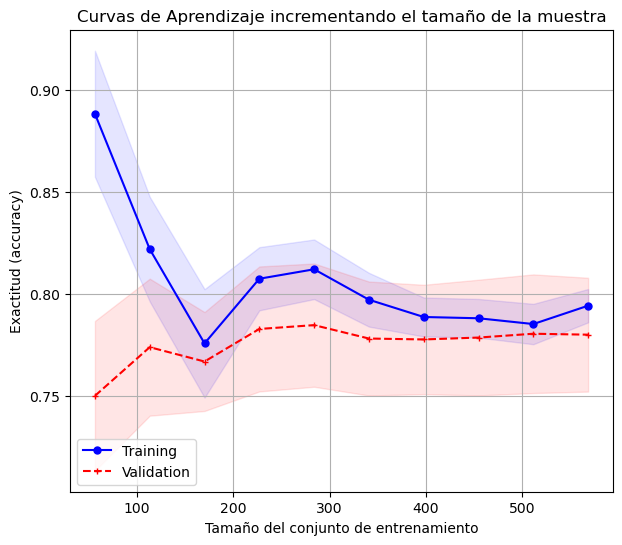

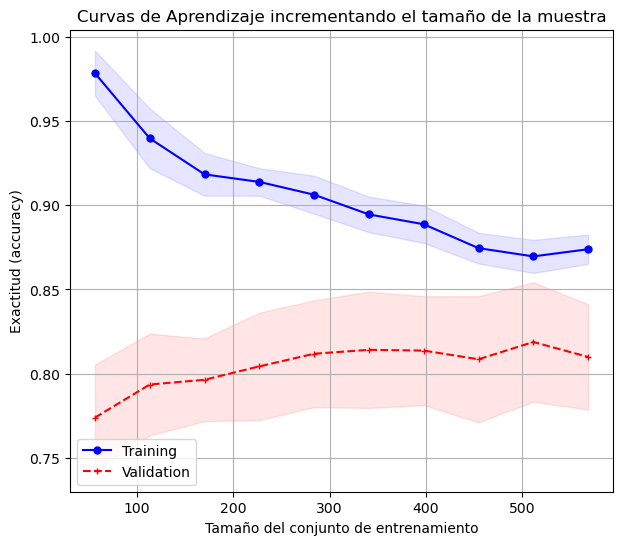

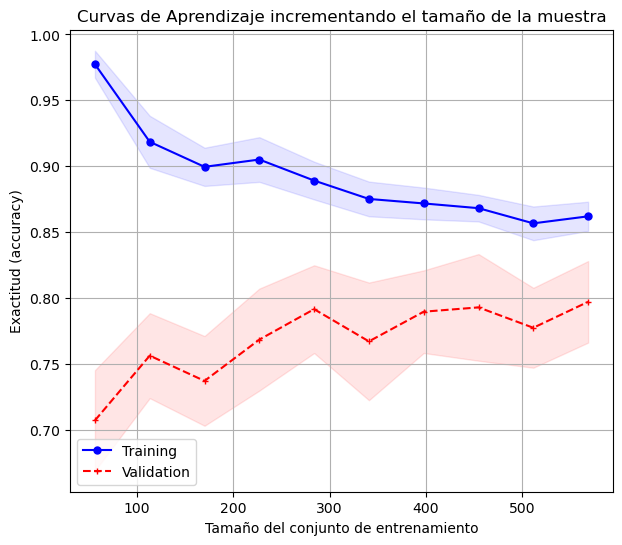

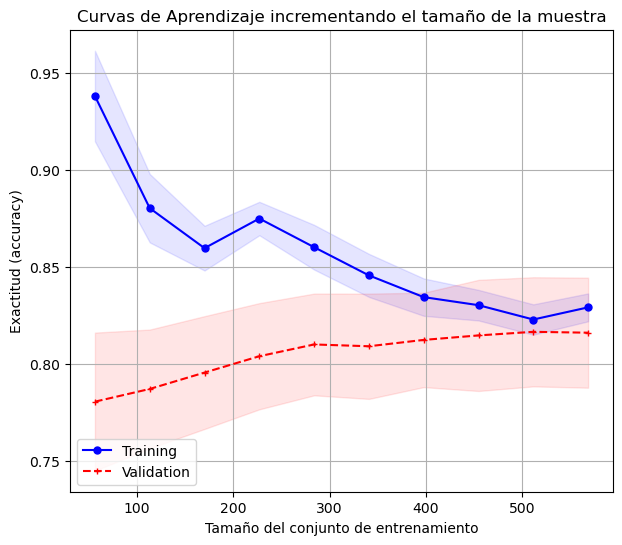

In [34]:
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve

results = list()
i=0
for modelo in modelos:
    
    pipeline_rf = Pipeline(steps=[('m',modelo)])
    pipeline_rf.fit(X_train,y_train)
    
    yhat_rf=cross_val_predict(pipeline_rf,X_test,y_test,cv=3)
    results.append((yhat_rf, nombres[i]))
    i += 1 

    mi_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    delta_train_sz = np.linspace(0.1, 1.0, 10)
    tr_sizes, tr_scores, val_scores = learning_curve(estimator=pipeline_rf,
                                                     X=X_train,
                                                     y=y_train,
                                                     cv=mi_kfold,
                                                     train_sizes=delta_train_sz,
                                                     random_state=11, 
                                                     n_jobs=30)
    mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

In [ ]:
from sklearn.model_selection import GridSearchCV
modelo = AdaBoostClassifier(n_estimators=100, random_state=42)


weights = np.linspace(0.0,0.99,5)

dicc_grid = {
               'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 1],
            }

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

grid = GridSearchCV(estimator=modelo,
                    param_grid=dicc_grid,
                    cv=cv,
                    scoring='f1', n_jobs=-1)

Xx = columnTransformer.fit_transform(X_train)


grid.fit(Xx, np.ravel(y_train))

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:',
      grid.best_params_)
print('Métrica utilizada:', grid.scoring)

In [35]:

from sklearn.metrics import accuracy_score,precision_score, recall_score, classification_report, f1_score

for yhat_rf, nombre in results:
    accuracy=accuracy_score(y_test,yhat_rf)
    precision=precision_score(y_test, yhat_rf, average='macro')
    recall=recall_score(y_test,yhat_rf,average="macro")
    f1=f1_score(y_test,yhat_rf,average="macro")
    print("Model: ", nombre)
    print("Accuracy:",accuracy)
    print("Precision:",precision)
    print("Recall:",recall)
    print("F1-Score:",f1)   
    print("------------------")

Model:  LR - Logistic Regression
Accuracy: 0.8379888268156425
Precision: 0.8326923076923077
Recall: 0.833976833976834
F1-Score: 0.8333065733277673
------------------
Model:  RF - Ranrom Forest
Accuracy: 0.8212290502793296
Precision: 0.8163940809968847
Recall: 0.8137065637065637
F1-Score: 0.8149392607909021
------------------
Model:  DT - Decision Tree
Accuracy: 0.7541899441340782
Precision: 0.7511877969492373
Recall: 0.7585585585585586
F1-Score: 0.7513888888888889
------------------
Model:  Ada Boost
Accuracy: 0.7988826815642458
Precision: 0.7951112877583466
Recall: 0.7866795366795367
F1-Score: 0.789906103286385
------------------


In [ ]:
for yhat_rf, nombre in results: 
    #print("Model: ", nombre)          
    print(classification_report(y_test, yhat_rf))
    #print("-")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

def mi_cm(yreal, ypred):
  cm=confusion_matrix(yreal, ypred)

  plt.figure(figsize=(12,8))
  plt.title("Matriz de confusión")
  ax = sns.heatmap(cm, annot=True, fmt='', cbar=True, cmap="Blues")
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.show()
    
# Confusion Matrix
mi_cm(y_test,results[0][0])

# Neural Network

In [69]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class TitanicDataset(Dataset):
    def __init__(self, dataframe, features, target):
        self.dataframe = dataframe
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = torch.tensor(self.dataframe[self.features].iloc[idx].values, dtype=torch.float32)
        y = torch.tensor(self.dataframe[self.target].iloc[idx], dtype=torch.long)

        return X, y

features = train_data_scaled.columns.tolist()
features.remove('Survived')
target = "Survived"
titanic_dataset = TitanicDataset(train_data_scaled.copy(), features, target)

# Split dataset
train_data_size = int(len(titanic_dataset)*0.8)
validation_data_size = int((len(titanic_dataset) - train_data_size)/2)
test_data_size = validation_data_size + 1


# Random split
train_data, validation_data, test_data = torch.utils.data.random_split(titanic_dataset, [train_data_size, validation_data_size, test_data_size])

# Define Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=64, num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, num_workers=4)




In [70]:
features, labels = next(iter(train_loader))
features = features[0].numpy()
features.shape

(22,)

In [153]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(22,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,4)
        self.fc4 = nn.Linear(4,2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [156]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [157]:
epochs = 1000
steps = 0
print_every = 20
running_loss = 0

train_losses, validation_losses = [], []
model.to(device)
validation_accuracy = 0

for epoch in range(epochs):
    for inputs, labels, in train_loader:
        steps += 1

        # Move inputs and label to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of the model and compute loss 
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            validation_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    validation_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
            model.train()
            
            train_losses.append(running_loss/len(train_loader))
            validation_losses.append(validation_loss/len(validation_loader))
            
            validation_accuracy = accuracy / len(validation_loader)

            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(validation_loss/len(validation_loader)),
              "Validation Accuracy: {:.3f}".format(validation_accuracy))
            
            running_loss = 0
            
            # Early stopping condition
            if validation_accuracy >= 0.88:
                print("Early stopping: Validation accuracy reached {:.3f}".format(validation_accuracy))
                break

    # Break out of the outer loop as well
    if validation_accuracy >= 0.88:
        break

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34d879a7a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f34d879a7a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Epoch: 2/1000..  Training Loss: 1.132..  Validation Loss: 0.678..  Validation Accuracy: 0.605
Epoch: 4/1000..  Training Loss: 1.123..  Validation Loss: 0.676..  Validation Accuracy: 0.605
Epoch: 5/1000..  Training Loss: 1.110..  Validation Loss: 0.674..  Validation Accuracy: 0.605
Epoch: 7/1000..  Training Loss: 1.115..  Validation Loss: 0.671..  Validation Accuracy: 0.605
Epoch: 9/1000..  Training Loss: 1.105..  Validation Loss: 0.666..  Validation Accuracy: 0.605
Epoch: 10/1000..  Training Loss: 1.091..  Validation Loss: 0.660..  Validation Accuracy: 0.605
Epoch: 12/1000..  Training Loss: 1.091..  Validation Loss: 0.649..  Validation Accuracy: 0.613
Epoch: 14/1000..  Training Loss: 1.057..  Validation Loss: 0.633..  Validation Accuracy: 0.679
Epoch: 15/1000..  Training Loss: 1.051..  Validation Loss: 0.616..  Validation Accuracy: 0.695
Epoch: 17/1000..  Training Loss: 1.036..  Validation Loss: 0.601..  Validation Accuracy: 0.691
Epoch: 19/1000..  Training Loss: 0.995..  Validation Lo

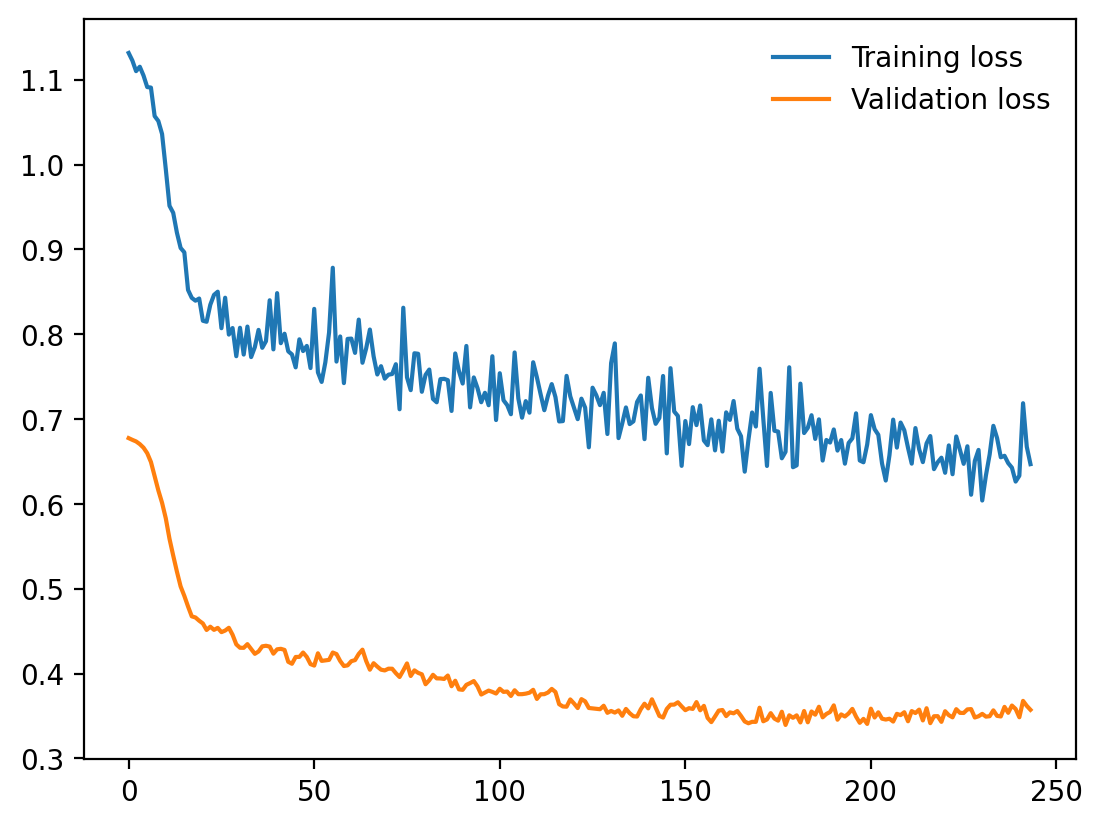

In [158]:
# training loss > validation loss???
# https://stats.stackexchange.com/a/205831

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

In [159]:
correct = 0
total = 0

model.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for features, labels in test_loader:        
        features, labels = features.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(features)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test data: {100 * correct // total} %')

Accuracy of the network on test data: 87 %
